<a href="https://colab.research.google.com/github/manuaishika/hon/blob/main/honeybee_imp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch torchvision matplotlib numpy

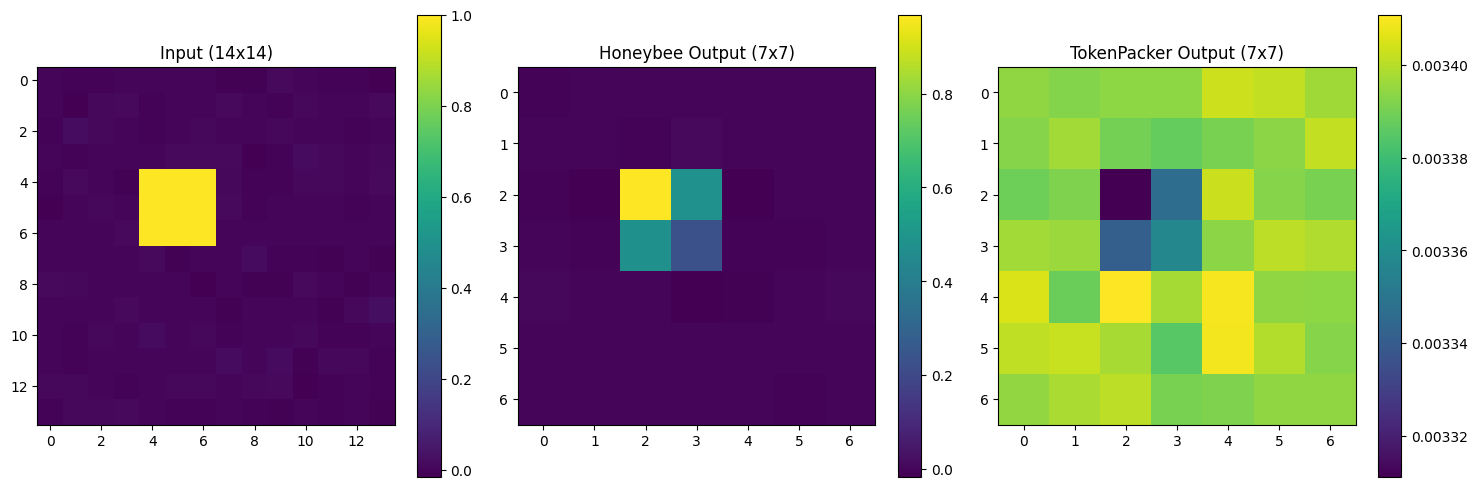

Honeybee: Center activation = 0.23, Edge activation = -0.00
TokenPacker: Center activation = 0.00, Edge activation = 0.00


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

# Set random seed for reproducibility
torch.manual_seed(42)

# Synthetic input: 14x14 feature map with localized activation
def create_synthetic_input():
    x = torch.randn(1, 256, 14, 14) * 0.1  # Gaussian noise, std=0.1
    x[:, :, 4:7, 4:7] = 1.0  # Localized 3x3 activation
    return x.cuda() if torch.cuda.is_available() else x

# Honeybee C-Abstractor (simplified)
class HoneybeeCAbstractor(nn.Module):
    def __init__(self, in_channels=256, out_channels=256):
        super().__init__()
        self.pre_res1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )
        self.pool = nn.AdaptiveAvgPool2d((7, 7))
        self.pre_res2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )

    def forward(self, x):
        x = x + self.pre_res1(x)  # Residual
        x = self.pool(x)
        x = x + self.pre_res2(x)  # Residual
        return x

# TokenPacker (simplified coarse-to-fine)
class TokenPacker(nn.Module):
    def __init__(self, in_channels=256, out_channels=256):
        super().__init__()
        self.downsample = nn.Upsample(scale_factor=0.5, mode='bilinear', align_corners=False)
        self.attn = nn.MultiheadAttention(embed_dim=in_channels, num_heads=8)
        self.mlp = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 1),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, 1)
        )

    def forward(self, x):
        # Coarse: bilinear downsample to 7x7
        coarse = self.downsample(x)  # [1, 256, 7, 7]
        B, C, H, W = coarse.shape
        coarse_flat = coarse.permute(0, 2, 3, 1).reshape(B, H*W, C)  # [1, 49, 256]

        # Local attention: each coarse query attends to 2x2 high-res region
        fine = x.permute(0, 2, 3, 1).reshape(B, 14*14, C)  # [1, 196, 256]

        # Transpose to sequence-first for MultiheadAttention
        coarse_flat = coarse_flat.transpose(0, 1)  # [49, 1, 256]
        fine = fine.transpose(0, 1)  # [196, 1, 256]

        attn_output, _ = self.attn(coarse_flat, fine, fine)  # Simplified local attention

        # Transpose back to batch-first
        attn_output = attn_output.transpose(0, 1)  # [1, 49, 256]

        attn_output = attn_output.reshape(B, H, W, C).permute(0, 3, 1, 2)  # [1, 256, 7, 7]

        # MLP update
        out = self.mlp(attn_output)
        return out

# Initialize models and input
input_tensor = create_synthetic_input()
honeybee = HoneybeeCAbstractor().cuda() if torch.cuda.is_available() else HoneybeeCAbstractor()
tokenpacker = TokenPacker().cuda() if torch.cuda.is_available() else TokenPacker()

# Inference
with torch.no_grad():
    honeybee.eval()
    tokenpacker.eval()
    honeybee_out = honeybee(input_tensor)
    tokenpacker_out = tokenpacker(input_tensor)

# Visualize heatmaps
def plot_heatmaps(input_tensor, honeybee_out, tokenpacker_out):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    titles = ['Input (14x14)', 'Honeybee Output (7x7)', 'TokenPacker Output (7x7)']
    data = [
        input_tensor[0].mean(dim=0).cpu().numpy(),
        honeybee_out[0].mean(dim=0).cpu().numpy(),
        tokenpacker_out[0].mean(dim=0).cpu().numpy()
    ]

    for ax, title, d in zip(axes, titles, data):
        im = ax.imshow(d, cmap='viridis')
        ax.set_title(title)
        fig.colorbar(im, ax=ax)
    plt.tight_layout()
    plt.show()

plot_heatmaps(input_tensor, honeybee_out, tokenpacker_out)

# Quantify locality preservation (mean activation in central 3x3 vs. edges in 7x7 outputs)
def quantify_locality(tensor):
    tensor = tensor[0].mean(dim=0).cpu().numpy()
    center = tensor[2:5, 2:5].mean()  # Central 3x3 (scaled for 7x7)
    edges = np.concatenate([tensor[0, :], tensor[-1, :], tensor[:, 0], tensor[:, -1]]).mean()
    return center, edges

honeybee_center, honeybee_edges = quantify_locality(honeybee_out)
tokenpacker_center, tokenpacker_edges = quantify_locality(tokenpacker_out)

print(f"Honeybee: Center activation = {honeybee_center:.2f}, Edge activation = {honeybee_edges:.2f}")
print(f"TokenPacker: Center activation = {tokenpacker_center:.2f}, Edge activation = {tokenpacker_edges:.2f}")

honeybee

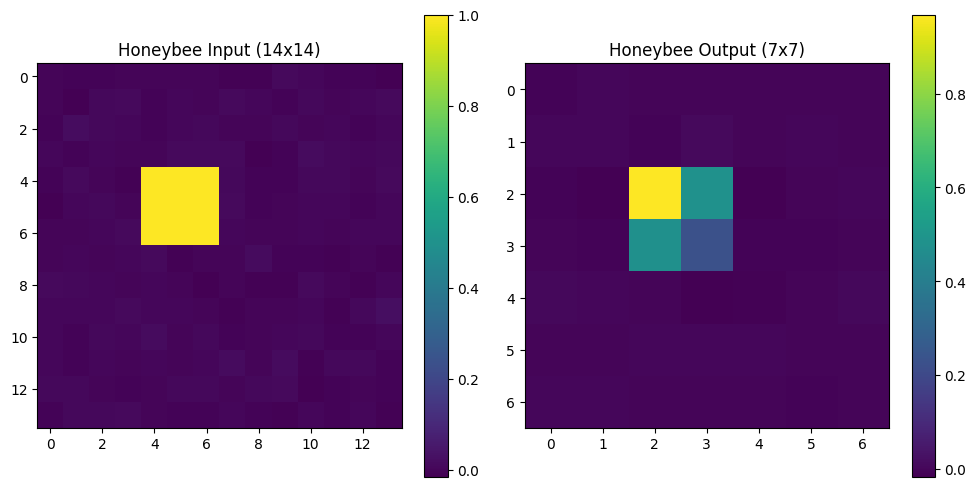

Honeybee: Center activation = 0.23, Edge activation = -0.00


In [4]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

# Set random seed for reproducibility
torch.manual_seed(42)

# Synthetic input: 14x14 feature map with localized activation
def create_synthetic_input_honeybee():
    x = torch.randn(1, 256, 14, 14) * 0.1  # Gaussian noise, std=0.1
    x[:, :, 4:7, 4:7] = 1.0  # Localized 3x3 activation
    return x.cuda() if torch.cuda.is_available() else x

# Honeybee C-Abstractor (simplified)
class HoneybeeCAbstractor(nn.Module):
    def __init__(self, in_channels=256, out_channels=256):
        super().__init__()
        self.pre_res1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )
        self.pool = nn.AdaptiveAvgPool2d((7, 7))
        self.pre_res2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )

    def forward(self, x):
        x = x + self.pre_res1(x)  # Residual
        x = self.pool(x)
        x = x + self.pre_res2(x)  # Residual
        return x

# Initialize model and input
input_honeybee = create_synthetic_input_honeybee()
honeybee = HoneybeeCAbstractor().cuda() if torch.cuda.is_available() else HoneybeeCAbstractor()

# Inference
with torch.no_grad():
    honeybee.eval()
    honeybee_out = honeybee(input_honeybee)

# Visualize heatmaps
def plot_heatmaps_honeybee(input_tensor, output_tensor):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    titles = ['Honeybee Input (14x14)', 'Honeybee Output (7x7)']
    data = [
        input_tensor[0].mean(dim=0).cpu().numpy(),
        output_tensor[0].mean(dim=0).cpu().numpy()
    ]

    for ax, title, d in zip(axes, titles, data):
        im = ax.imshow(d, cmap='viridis')
        ax.set_title(title)
        fig.colorbar(im, ax=ax)
    plt.tight_layout()
    plt.show()

plot_heatmaps_honeybee(input_honeybee, honeybee_out)

# Quantify locality preservation
def quantify_locality(tensor):
    tensor = tensor[0].mean(dim=0).cpu().numpy()
    center = tensor[2:5, 2:5].mean()  # Central 3x3 (scaled for 7x7)
    edges = np.concatenate([tensor[0, :], tensor[-1, :], tensor[:, 0], tensor[:, -1]]).mean()
    return center, edges

honeybee_center, honeybee_edges = quantify_locality(honeybee_out)
print(f"Honeybee: Center activation = {honeybee_center:.2f}, Edge activation = {honeybee_edges:.2f}")

navit


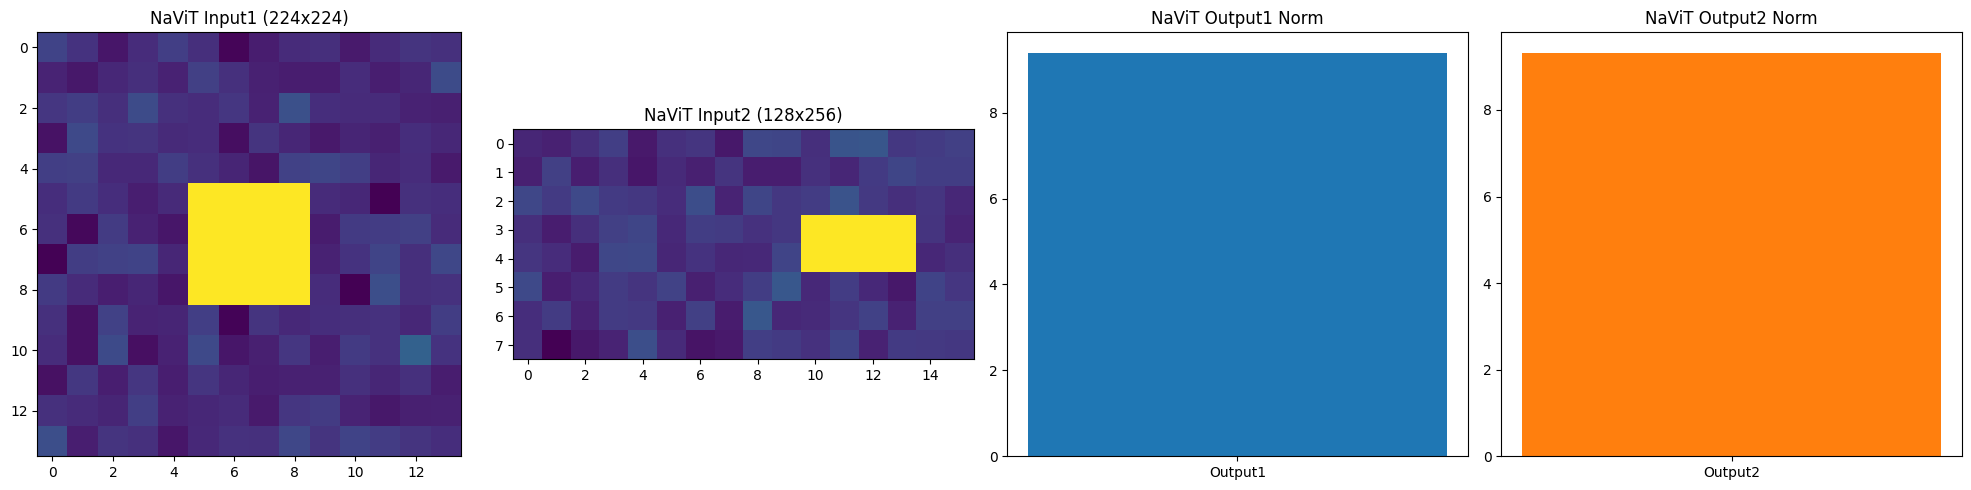

NaViT: Input1 norm = 116.98, Output1 norm = 9.40
NaViT: Input2 norm = 84.05, Output2 norm = 9.33


In [9]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

# Set random seed for reproducibility
torch.manual_seed(42)

# Synthetic inputs for NaViT: Two variable-res "images"
def create_synthetic_inputs_navit():
    img1 = torch.randn(1, 3, 224, 224) * 0.1  # Square image
    img1[:, :, 80:144, 80:144] = 1.0  # ~64x64 central patch

    img2 = torch.randn(1, 3, 128, 256) * 0.1  # Elongated image
    img2[:, :, 48:80, 160:224] = 1.0  # Localized right patch

    return [img1.cuda() if torch.cuda.is_available() else img1,
            img2.cuda() if torch.cuda.is_available() else img2]

# NaViT (simplified ViT with Patch n’ Pack)
class NaViT(nn.Module):
    def __init__(self, patch_size=16, embed_dim=256, num_heads=8, num_layers=2):
        super().__init__()
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        self.patch_embed = nn.Conv2d(3, embed_dim, kernel_size=patch_size, stride=patch_size)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads)
        self.mlp = nn.Sequential(nn.Linear(embed_dim, embed_dim * 4), nn.GELU(), nn.Linear(embed_dim * 4, embed_dim))
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)

    def get_pos_emb(self, h, w, device):  # Factorized fractional sinusoidal pos embeds
        # Generate relative coordinates for each patch
        y_coords = torch.linspace(0, 1, h, device=device)
        x_coords = torch.linspace(0, 1, w, device=device)
        grid_y, grid_x = torch.meshgrid(y_coords, x_coords, indexing='ij')
        pos_y = torch.sin(grid_y * np.pi).flatten()
        pos_x = torch.cos(grid_x * np.pi).flatten()

        # Combine into [num_patches, embed_dim]
        pos = torch.cat([pos_y.unsqueeze(-1), pos_x.unsqueeze(-1)], dim=-1).repeat(1, self.embed_dim // 2)
        pos = pos[:h*w]  # Ensure length matches number of patches
        return pos.unsqueeze(0).expand(1, -1, self.embed_dim)  # [1, h*w, embed_dim]

    def forward(self, images):
        tokens = []
        lengths = []
        for img in images:
            patches = self.patch_embed(img)  # [1, embed_dim, h, w]
            h, w = img.shape[2] // self.patch_size, img.shape[3] // self.patch_size
            patches = patches.flatten(2).transpose(1, 2)  # [1, h*w, embed_dim]
            pos_emb = self.get_pos_emb(h, w, img.device)  # Move pos_emb to img's device
            patches = patches + pos_emb  # Add positional embeddings
            tokens.append(patches.squeeze(0))
            lengths.append(patches.shape[1])

        # Pack tokens into single sequence
        packed = torch.cat(tokens, dim=0).unsqueeze(0)  # [1, total_tokens, embed_dim]

        # Masked attention: Prevent cross-image attention
        total_length = sum(lengths)
        mask = torch.zeros(total_length, total_length, dtype=bool, device=img.device)
        start = 0
        for l in lengths:
            mask[start:start+l, start:start+l] = True  # Attend only within image
            start += l
        mask = mask.logical_not() * -1e9  # Mask non-attending positions

        # Transformer layers
        x = packed
        for _ in range(2):  # Simple 2 layers
            x = self.norm1(x)
            attn_output, _ = self.attn(x.transpose(0, 1), x.transpose(0, 1), x.transpose(0, 1), attn_mask=mask)
            x = x + attn_output.transpose(0, 1)
            x = x + self.mlp(self.norm2(x))

        # Unpack and pool per image
        outputs = []
        start = 0
        for l in lengths:
            img_out = x[:, start:start+l].mean(dim=1)  # Mean pool per image
            outputs.append(img_out)
            start += l
        return outputs

# Initialize model and inputs
inputs_navit = create_synthetic_inputs_navit()
navit = NaViT().cuda() if torch.cuda.is_available() else NaViT()

# Inference
with torch.no_grad():
    navit.eval()
    navit_out = navit(inputs_navit)

# Visualize heatmaps
def plot_heatmaps_navit(inputs, outputs):
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    titles = ['NaViT Input1 (224x224)', 'NaViT Input2 (128x256)', 'NaViT Output1 Norm', 'NaViT Output2 Norm']

    # Inputs (downsample for viz)
    axes[0].imshow(inputs[0][0].mean(0).cpu().numpy()[::16, ::16], cmap='viridis')
    axes[0].set_title(titles[0])
    axes[1].imshow(inputs[1][0].mean(0).cpu().numpy()[::16, ::16], cmap='viridis')
    axes[1].set_title(titles[1])

    # Outputs as bar plot of norms (since pooled)
    norms = [out.norm().item() for out in outputs]
    axes[2].bar(['Output1'], [norms[0]], color='#1f77b4')
    axes[2].set_title(titles[2])
    axes[3].bar(['Output2'], [norms[1]], color='#ff7f0e')
    axes[3].set_title(titles[3])

    plt.tight_layout()
    plt.show()

plot_heatmaps_navit(inputs_navit, navit_out)

# Quantify resolution preservation
navit_norms = [out.norm().item() for out in navit_out]
print(f"NaViT: Input1 norm = {inputs_navit[0][0].norm().item():.2f}, Output1 norm = {navit_norms[0]:.2f}")
print(f"NaViT: Input2 norm = {inputs_navit[1][0].norm().item():.2f}, Output2 norm = {navit_norms[1]:.2f}")

navit 2

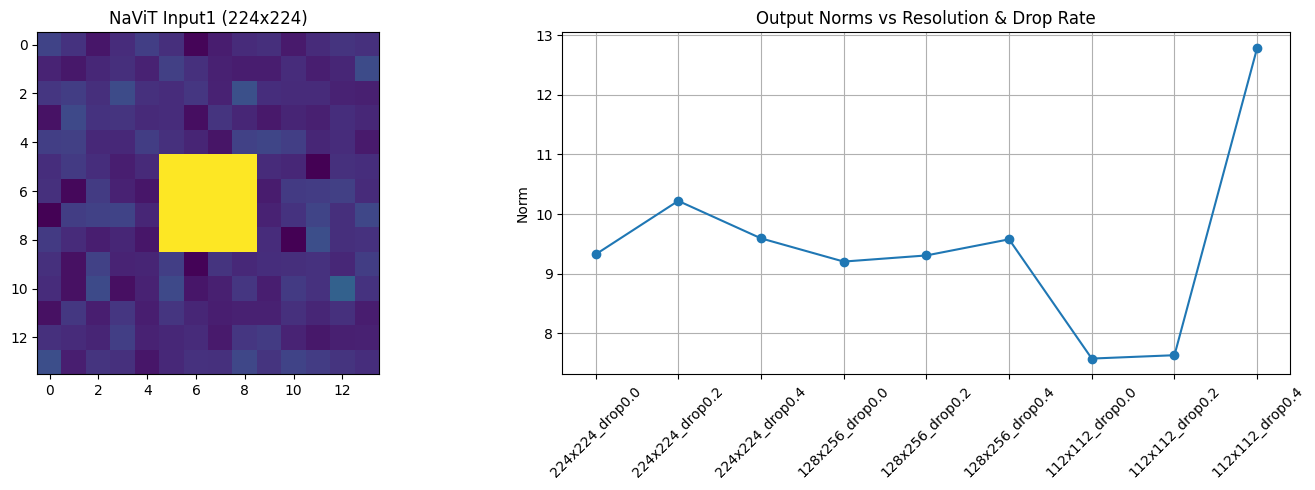

NaViT: 224x224_drop0.0 = 9.32
NaViT: 224x224_drop0.2 = 10.22
NaViT: 224x224_drop0.4 = 9.59
NaViT: 128x256_drop0.0 = 9.20
NaViT: 128x256_drop0.2 = 9.31
NaViT: 128x256_drop0.4 = 9.58
NaViT: 112x112_drop0.0 = 7.58
NaViT: 112x112_drop0.2 = 7.63
NaViT: 112x112_drop0.4 = 12.79


In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

# Set random seed for reproducibility
torch.manual_seed(42)

# Synthetic inputs for NaViT: Variable-res "images" with optional resolution scaling
def create_synthetic_inputs_navit(resolutions=[(224, 224), (128, 256)], scale_factor=1.0):
    inputs = []
    for h, w in resolutions:
        img = torch.randn(1, 3, int(h * scale_factor), int(w * scale_factor)) * 0.1
        if h == 224:
            img[:, :, int(80*scale_factor):int(144*scale_factor), int(80*scale_factor):int(144*scale_factor)] = 1.0  # Central patch
        else:
            img[:, :, int(48*scale_factor):int(80*scale_factor), int(160*scale_factor):int(224*scale_factor)] = 1.0  # Right patch
        inputs.append(img.cuda() if torch.cuda.is_available() else img)
    return inputs

# NaViT (enhanced with token dropping and resolution flexibility)
class NaViT(nn.Module):
    def __init__(self, patch_size=16, embed_dim=256, num_heads=8, num_layers=2):
        super().__init__()
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        self.patch_embed = nn.Conv2d(3, embed_dim, kernel_size=patch_size, stride=patch_size)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads)
        self.mlp = nn.Sequential(nn.Linear(embed_dim, embed_dim * 4), nn.GELU(), nn.Linear(embed_dim * 4, embed_dim))
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)

    def get_pos_emb(self, h, w, device):  # Factorized fractional sinusoidal pos embeds
        y_coords = torch.linspace(0, 1, h, device=device)
        x_coords = torch.linspace(0, 1, w, device=device)
        grid_y, grid_x = torch.meshgrid(y_coords, x_coords, indexing='ij')
        pos_y = torch.sin(grid_y * np.pi).flatten()
        pos_x = torch.cos(grid_x * np.pi).flatten()
        pos = torch.cat([pos_y.unsqueeze(-1), pos_x.unsqueeze(-1)], dim=-1).repeat(1, self.embed_dim // 2)
        pos = pos[:h*w]
        return pos.unsqueeze(0).expand(1, -1, self.embed_dim)

    def forward(self, images, drop_rate=0.2):
        tokens = []
        lengths = []
        for img in images:
            patches = self.patch_embed(img)  # [1, embed_dim, h, w]
            h, w = img.shape[2] // self.patch_size, img.shape[3] // self.patch_size
            patches = patches.flatten(2).transpose(1, 2)  # [1, h*w, embed_dim]
            pos_emb = self.get_pos_emb(h, w, img.device)
            patches = patches + pos_emb

            # Continuous token dropping
            num_drop = int(patches.shape[1] * drop_rate)
            if num_drop > 0:
                drop_indices = torch.randperm(patches.shape[1], device=img.device)[:num_drop]
                patches = patches.index_select(1, torch.tensor([i for i in range(patches.shape[1]) if i not in drop_indices], device=img.device))

            tokens.append(patches.squeeze(0))
            lengths.append(patches.shape[1])

        # Pack tokens into single sequence
        packed = torch.cat(tokens, dim=0).unsqueeze(0)  # [1, total_tokens, embed_dim]

        # Masked attention
        total_length = sum(lengths)
        mask = torch.zeros(total_length, total_length, dtype=bool, device=img.device)
        start = 0
        for l in lengths:
            mask[start:start+l, start:start+l] = True
            start += l
        mask = mask.logical_not() * -1e9

        # Transformer layers
        x = packed
        for _ in range(2):
            x = self.norm1(x)
            attn_output, _ = self.attn(x.transpose(0, 1), x.transpose(0, 1), x.transpose(0, 1), attn_mask=mask)
            x = x + attn_output.transpose(0, 1)
            x = x + self.mlp(self.norm2(x))

        # Unpack and pool per image
        outputs = []
        start = 0
        for l in lengths:
            img_out = x[:, start:start+l].mean(dim=1)
            outputs.append(img_out)
            start += l
        return outputs

# Initialize model and inputs
inputs_navit = create_synthetic_inputs_navit()
navit = NaViT().cuda() if torch.cuda.is_available() else NaViT()

# Inference with variable resolutions and token dropping
resolutions = [(224, 224), (128, 256), (112, 112)]  # Test different resolutions
drop_rates = [0.0, 0.2, 0.4]  # Test different drop rates
results = {}

for res, drop in [(r, d) for r in resolutions for d in drop_rates]:
    inputs = create_synthetic_inputs_navit([res], scale_factor=1.0 if res==(224,224) or res==(128,256) else res[0]/224)
    with torch.no_grad():
        navit.eval()
        navit_out = navit(inputs, drop_rate=drop)
    norms = [out.norm().item() for out in navit_out]
    results[f"{res[0]}x{res[1]}_drop{drop}"] = norms[0]  # Store norm of first image

# Visualize enhanced heatmaps and norms
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Heatmap for first input at native resolution
ax1.imshow(inputs_navit[0][0].mean(0).cpu().numpy()[::16, ::16], cmap='viridis')
ax1.set_title('NaViT Input1 (224x224)')

# Line plot of norms across resolutions and drop rates
res_labels = [f"{r[0]}x{r[1]}_drop{d}" for r in resolutions for d in drop_rates]
norm_values = [results[label] for label in res_labels]
ax2.plot(range(len(norm_values)), norm_values, marker='o')
ax2.set_xticks(range(len(norm_values)))
ax2.set_xticklabels(res_labels, rotation=45)
ax2.set_title('Output Norms vs Resolution & Drop Rate')
ax2.set_ylabel('Norm')
ax2.grid(True)

plt.tight_layout()
plt.show()

# Print detailed results
for label, norm in results.items():
    print(f"NaViT: {label} = {norm:.2f}")